In [3]:
from climateclassifier.climateclassy import DataLoader
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.cmiknn import CMIknn

2024-09-02 19:35:46.469137: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 19:35:48.530987: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 19:35:48.542420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 19:35:53.930966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Notebook 3: Identifying climatic causal graphs
This tutorial follows the basical steps to identify and visualize a temporal causal graph from a climatic dataframe. Linear and non-linear conditional independence tests are also compared. This tutorial serves as an introductory example, the process for the hole dataset has been automated at causef.py. See Section 3.2.3. for more information.


The class DataLoader has been writen specifically for this project. It allows to load our dataset as a numpy array with dimensions pixel x time x climatic variable. It also allows to substract time-series seasonality if needed. It is interesting to note that, if we had to deal with a different dataset, we would just need to adapt this class to load the new data format following the same structure, and all subsequent analysis on this project can be easily automated.

In [4]:
df_path = './data/ugent_data'
variables = ['max_5consec_Ix5dayRN_ERA','max_5consec_Sx5daySM_GLEAM','T_CRU_Residuals','monthly_Rx1day_P_CPCU']

data = DataLoader(df_path, variables, data_format = 'csv', substract_seasonality=[True, True, True, True])

For this example, we decided to randomly choose and average 10 different pixels corresponding to the tropical climatic cluster. A single pixel could contain anomalies, outliers or measurment errors. We also tested that averaging over thousands of pixels on each climatic cluster resulted on smoothed functions and loss of information.

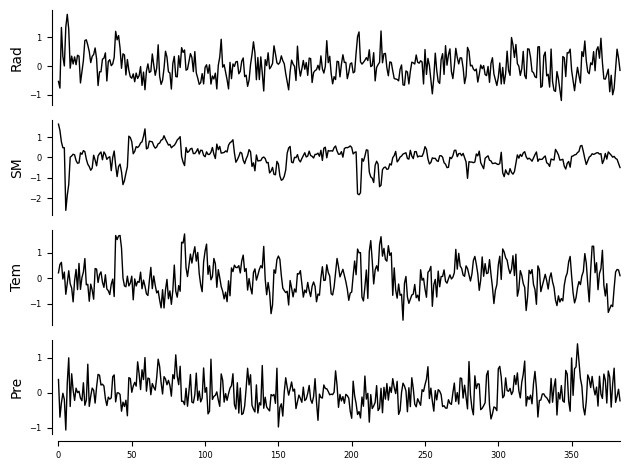

In [5]:
trop = [1, 59, 612, 929, 1007, 1432, 1623, 11715, 1176, 8836] # pixel index of 10 different tropical regions
# if we want to find coordinates of index 59, for example: data.latitud[59], data.longitud[59]

variables = ['Rad','SM','Tem','Pre']

# we load the averaged series on a Tigramite dataframe
df0 = pp.DataFrame(np.mean(data.df[trop,:,:], axis=0), var_names= variables)
tp.plot_timeseries(df0); plt.show()

One interesting feature of Tigramite allows to integrate expert assumptions on the algorithm. For example, in this case we can assume that Soil Moisture, Temperature and Precipitation cannot physically cause the radiation coming from the sun. Therefore, we include the fact that each discovered link between the former and the latter, if exists must be caused by Radiation (represented by '<?-'). When using link_assumptions in tigramite, all other links to be tested must be specified such as 'o?o' or will be considered as non existent, and not tested.   

In [6]:
link_assumptions = {}
N = 4
tau_max = 2

link_assumptions[0] = {
    (i, -tau): '<?-' if (i, -tau) != (0, 0) and i != 0 else 'o?o'
    for i in range(N)
    for tau in range(tau_max + 1)
    if (i, -tau) != (0, 0)  # Filtering condition to exclude (1, 0)
}

link_assumptions[1] = {
    (i, -tau): '-?>' if (i, -tau) != (1, 0) and i == 0 else 'o?o'
    for i in range(N)
    for tau in range(tau_max + 1)
    if (i, -tau) != (1, 0)  # Filtering condition to exclude (1, 0)
}

link_assumptions[2] = {
    (i, -tau): '-?>' if (i, -tau) != (2, 0) and i == 0 else 'o?o'
    for i in range(N)
    for tau in range(tau_max + 1)
    if (i, -tau) != (2, 0)  # Filtering condition to exclude (1, 0)
}

link_assumptions[3] = {
    (i, -tau): '-?>' if (i, -tau) != (3, 0) and i == 0 else 'o?o'
    for i in range(N)
    for tau in range(tau_max + 1)
    if (i, -tau) != (3, 0)  # Filtering condition to exclude (1, 0)
}

Entries on link_assumptions are defined as j: (i, -t): 'o?o', which means link from variable i to variable j at lag -t must be tested (we have no assumption about this link).

For example:   0: (1, -2): '<?-' means that the algorithm must test if there exists a causal link between variable variable 1 (Soil Moisture) and 0 (radiation), and if the link exists, it will be oriented 1 <- 0.

In [15]:
print(link_assumptions)

{0: {(0, -1): 'o?o', (0, -2): 'o?o', (1, 0): '<?-', (1, -1): '<?-', (1, -2): '<?-', (2, 0): '<?-', (2, -1): '<?-', (2, -2): '<?-', (3, 0): '<?-', (3, -1): '<?-', (3, -2): '<?-'}, 1: {(0, 0): '-?>', (0, -1): '-?>', (0, -2): '-?>', (1, -1): 'o?o', (1, -2): 'o?o', (2, 0): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, 0): 'o?o', (3, -1): 'o?o', (3, -2): 'o?o'}, 2: {(0, 0): '-?>', (0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): 'o?o', (1, -2): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, 0): 'o?o', (3, -1): 'o?o', (3, -2): 'o?o'}, 3: {(0, 0): '-?>', (0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): 'o?o', (1, -2): 'o?o', (2, 0): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, -1): 'o?o', (3, -2): 'o?o'}}


Now we are able to compute the causal graph, with a linear conditional independence test, and visualize it:

In [9]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=df0, 
    cond_ind_test=parcorr,
    verbosity=1)

results = pcmci.run_pcmci(tau_max=2, pc_alpha=None, link_assumptions=link_assumptions)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
link_assumptions = {0: {(0, -1): 'o?o', (0, -2): 'o?o', (1, 0): '<?-', (1, -1): '<?-', (1, -2): '<?-', (2, 0): '<?-', (2, -1): '<?-', (2, -2): '<?-', (3, 0): '<?-', (3, -1): '<?-', (3, -2): '<?-'}, 1: {(0, 0): '-?>', (0, -1): '-?>', (0, -2): '-?>', (1, -1): 'o?o', (1, -2): 'o?o', (2, 0): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, 0): 'o?o', (3, -1): 'o?o', (3, -2): 'o?o'}, 2: {(0, 0): '-?>', (0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): 'o?o', (1, -2): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, 0): 'o?o', (3, -1): 'o?o', (3, -2): 'o?o'}, 3: {(0, 0): '-?>', (0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): 'o?o', (1, -2): 'o?o', (2, 0): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, -1): 'o?o', (3, -2): 'o?o'}}
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Varia

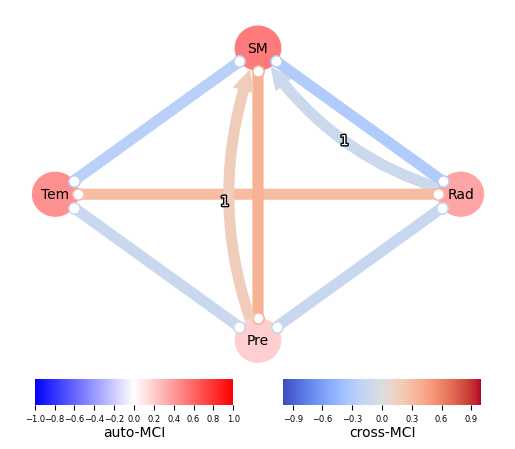

In [10]:
graph = pcmci.get_graph_from_pmatrix(p_matrix=results['p_matrix'], alpha_level=0.05, tau_min=1, tau_max=2)

tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=graph,
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    edge_ticks=0.3,
    cmap_edges='coolwarm',
    node_ticks=.2,
    cmap_nodes='bwr',
    ); 
plt.show()


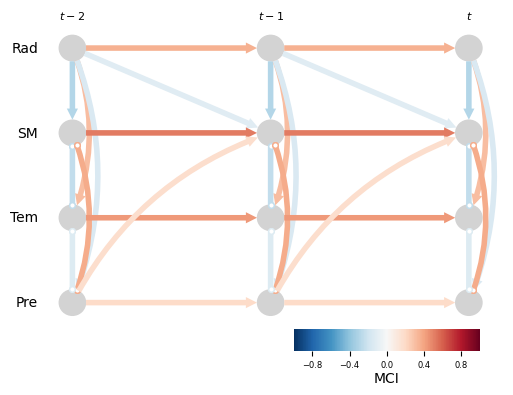

In [11]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=variables,
    link_colorbar_label='MCI',
    ); plt.show()

And with a non-linear conditional independence test:

In [8]:
cmi_knn = CMIknn( model_selection_folds=3)
pcmci_cmi_knn = PCMCI(dataframe=df0, cond_ind_test=cmi_knn, verbosity=2)
results = pcmci_cmi_knn.run_pcmciplus(tau_max=2, pc_alpha=None, link_assumptions = link_assumptions) 


##
## Optimizing pc_alpha over pc_alpha_list = [0.001, 0.005, 0.01, 0.025, 0.05]
##

## pc_alpha = 0.001 (1/5):

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
link_assumptions = {0: {(0, -1): 'o?o', (0, -2): 'o?o', (1, 0): '<?-', (1, -1): '<?-', (1, -2): '<?-', (2, 0): '<?-', (2, -1): '<?-', (2, -2): '<?-', (3, 0): '<?-', (3, -1): '<?-', (3, -2): '<?-'}, 1: {(0, 0): '-?>', (0, -1): '-?>', (0, -2): '-?>', (1, -1): 'o?o', (1, -2): 'o?o', (2, 0): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, 0): 'o?o', (3, -1): 'o?o', (3, -2): 'o?o'}, 2: {(0, 0): '-?>', (0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): 'o?o', (1, -2): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, 0): 'o?o', (3, -1): 'o?o', (3, -2): 'o?o'}, 3: {(0, 0): '-?>', (0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): 'o?o', (1, -2): 'o?o', (2, 0): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, -1): 'o?o', (3, -2): 'o?o'}}
independence test = cmi_knn
tau_min = 1
tau_max = 2
pc_alpha = [0.001]
max_con

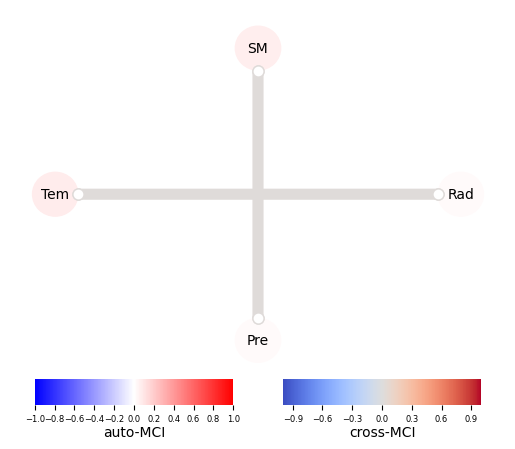

In [11]:
graph = pcmci_cmi_knn.get_graph_from_pmatrix(p_matrix=results['p_matrix'], alpha_level=0.05, tau_min=1, tau_max=2)

tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=graph,
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    edge_ticks=0.3,
    cmap_edges='coolwarm',
    node_ticks=.2,
    cmap_nodes='bwr',
    ); 
plt.show()

We can clearly see that, on this example, results from the linear test seem more reasonable. We can also see that the linear test took 0.7 s and the non-parametric took 22 minuts. This example, extrapolated to a dataset with 13000 different pixels has suggested the use of linear tests for subsequent experiments.